In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/My\ Drive/Colab\ Notebooks/SR/SRCNN_run

/content/drive/My Drive/Colab Notebooks/SR/SRCNN_run


In [0]:
import os
from os import listdir
from os.path import join

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from PIL import Image, ImageFilter

import argparse
import math
from math import log10

import torch
import torch.nn as nn
import torch.optim as optim

import copy
import numpy as np
import torchvision
import torchvision.datasets as datasets
import torchvision.models as torch_models
import torch.nn.functional as F
import time
import datetime
import sys

Ref. code : https://github.com/Mirwaisse/SRCNN

In [0]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out

In [0]:
# whether an image or not
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

# change to greyscale
def load_image(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y

In [0]:
location = '/content/drive/My Drive/Colab Notebooks/SR/SRCNN_run/koala.jpg'

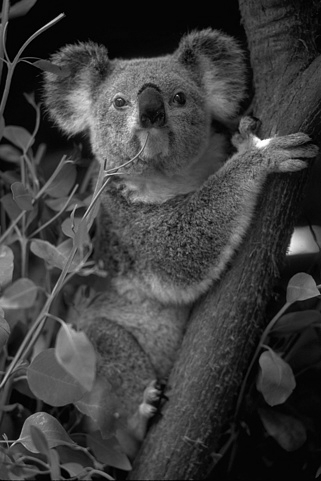

In [0]:
grey_img = load_image(location)
grey_img
#grey_img.save("grey.jpg")

In [0]:
CROP_SIZE = 32
ZOOM_FACTOR = 2
EPOCHS = 200
CUDA = 'True'

BATCH_SIZE = 4
NUM_WORKERS = 0 # on Windows, set this variable to 0(by Ref.)

In [0]:
class DatasetFromFolder(Dataset):
    def __init__(self, image_dir, zoom_factor):

        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        crop_size = CROP_SIZE - (CROP_SIZE % zoom_factor) # Valid crop size
 
        self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), 
                                      transforms.Resize(crop_size//zoom_factor),   
                                      transforms.Resize(crop_size, interpolation=Image.BICUBIC),  # bicubic upsampling to get back the original size(by Ref.) 
                                      transforms.ToTensor()])
        self.target_transform = transforms.Compose([transforms.CenterCrop(crop_size), 
                                       transforms.ToTensor()])

    def __getitem__(self, index):
        input = load_image(self.image_filenames[index])
        target = input.copy() 
        
        input = self.input_transform(input) 
        target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.image_filenames)

In [0]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and CUDA) else "cpu")
torch.manual_seed(12)
torch.cuda.manual_seed(12)
print(device)

cuda:0


In [0]:
trainset = DatasetFromFolder("/content/drive/My Drive/Colab Notebooks/SR/SRCNN_run/data/train", zoom_factor=ZOOM_FACTOR)
testset = DatasetFromFolder("/content/drive/My Drive/Colab Notebooks/SR/SRCNN_run/data/test", zoom_factor=ZOOM_FACTOR)

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Model training

In [0]:
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(  # we use Adam instead of SGD like in the paper, because it's faster(by Ref.)
    [
        {"params": model.conv1.parameters(), "lr": 0.0001},  
        {"params": model.conv2.parameters(), "lr": 0.0001},
        {"params": model.conv3.parameters(), "lr": 0.00001},
    ], lr=0.00001,
)

In [0]:
EPOCHS = 100

In [0]:
training_time = time.time()
for epoch in range(1, EPOCHS + 1):

    # Train
    start_time = time.time()

    epoch_loss = 0
    for iteration, batch in enumerate(trainloader):
        input, target = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()

        out = model(input)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print("epoch {0}/{1} --- Training loss: {2:0.5f} --- {3:0.3f} seconds --- ".format(epoch, EPOCHS, epoch_loss / len(trainloader), time.time() - start_time))
#        avg_psnr = 0
#        with torch.no_grad():
#            for batch in testloader:
#                input, target = batch[0].to(device), batch[1].to(device)
#
#                out = model(input)
#                loss = criterion(out, target)
#                psnr = 10 * log10(1 / loss.item())
#                avg_psnr += psnr
#
#    print("epoch {0}/{1} --- Training loss: {2:0.5f} --- Average PSNR: {3}dB --- {4:0.3f} seconds --- ".format(epoch, EPOCHS, epoch_loss / len(trainloader), avg_psnr / len(testloader),time.time() - start_time))
   
print("Total training time : {} seconds --- ".format(str(datetime.timedelta(seconds=time.time() - training_time))))

epoch 1/100 --- Training loss: 0.17288 --- 1.349 seconds --- 
epoch 2/100 --- Training loss: 0.04054 --- 1.342 seconds --- 
epoch 3/100 --- Training loss: 0.02583 --- 1.312 seconds --- 
epoch 4/100 --- Training loss: 0.02275 --- 1.333 seconds --- 
epoch 5/100 --- Training loss: 0.01827 --- 1.350 seconds --- 
epoch 6/100 --- Training loss: 0.01373 --- 1.344 seconds --- 
epoch 7/100 --- Training loss: 0.01055 --- 1.335 seconds --- 
epoch 8/100 --- Training loss: 0.00874 --- 1.316 seconds --- 
epoch 9/100 --- Training loss: 0.00767 --- 1.332 seconds --- 
epoch 10/100 --- Training loss: 0.00691 --- 1.358 seconds --- 
epoch 11/100 --- Training loss: 0.00621 --- 1.425 seconds --- 
epoch 12/100 --- Training loss: 0.00569 --- 1.276 seconds --- 
epoch 13/100 --- Training loss: 0.00527 --- 1.323 seconds --- 
epoch 14/100 --- Training loss: 0.00502 --- 1.352 seconds --- 
epoch 15/100 --- Training loss: 0.00472 --- 1.371 seconds --- 
epoch 16/100 --- Training loss: 0.00454 --- 1.341 seconds --- 
e

In [0]:
# Test
avg_psnr = 0
with torch.no_grad():
    for batch in testloader:
        input, target = batch[0].to(device), batch[1].to(device)

        out = model(input)
        loss = criterion(out, target)
        psnr = 10 * log10(1 / loss.item())
        avg_psnr += psnr
print(f"Average PSNR: {avg_psnr / len(testloader)} dB.")
 

Average PSNR: 26.210212501654446 dB.


# Change LR to SR

In [0]:
IMAGE_LOC = '/content/drive/My Drive/Colab Notebooks/SR/SRCNN_run/koala.jpg'
LR = Image.open(IMAGE_LOC).convert('YCbCr')
# first, we upscale the image via bicubic interpolation(by Ref.)
LR = LR.resize((int(LR.size[0]*ZOOM_FACTOR), int(LR.size[1]*ZOOM_FACTOR)), Image.BICUBIC)  
y, cb, cr = LR.split()
LR_show = Image.merge('YCbCr', [y, cb, cr]).convert('RGB')
LR_show
LR_show.save("koala_bicubic.jpg")

In [0]:
img_to_tensor = transforms.ToTensor()
# we only work with the "Y" channel(by Ref.)
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]) 
input = input.to(device)

out = model(input)
out = out.cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')
out_img
out_img.save("koala_srcnn.jpg")

In [0]:
IMAGE_LOC = '/content/drive/My Drive/Colab Notebooks/SR/SRCNN_run/one.PNG'
LR = Image.open(IMAGE_LOC).convert('YCbCr')
# first, we upscale the image via bicubic interpolation(by Ref.)
LR = LR.resize((int(LR.size[0]*ZOOM_FACTOR), int(LR.size[1]*ZOOM_FACTOR)), Image.BICUBIC)  
y, cb, cr = LR.split()
LR_show = Image.merge('YCbCr', [y, cb, cr]).convert('RGB')
LR_show
LR_show.save("one_bicubic.PNG")

In [0]:
img_to_tensor = transforms.ToTensor()
# we only work with the "Y" channel(by Ref.)
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]) 
input = input.to(device)

out = model(input)
out = out.cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')
out_img.save("one_srcnn.PNG")

In [0]:
IMAGE_LOC = '/content/drive/My Drive/Colab Notebooks/SR/SRCNN_run/two.PNG'
LR = Image.open(IMAGE_LOC).convert('YCbCr')
# first, we upscale the image via bicubic interpolation(by Ref.)
LR = LR.resize((int(LR.size[0]*ZOOM_FACTOR), int(LR.size[1]*ZOOM_FACTOR)), Image.BICUBIC)  
y, cb, cr = LR.split()
LR_show = Image.merge('YCbCr', [y, cb, cr]).convert('RGB')
LR_show
LR_show.save("two_bicubic.PNG")

In [0]:
img_to_tensor = transforms.ToTensor()
# we only work with the "Y" channel(by Ref.)
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]) 
input = input.to(device)

out = model(input)
out = out.cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')
out_img
out_img.save("two_srcnn.PNG")

In [0]:
IMAGE_LOC = '/content/drive/My Drive/Colab Notebooks/SR/SRCNN_run/three.PNG'
LR = Image.open(IMAGE_LOC).convert('YCbCr')
# first, we upscale the image via bicubic interpolation(by Ref.)
LR = LR.resize((int(LR.size[0]*ZOOM_FACTOR), int(LR.size[1]*ZOOM_FACTOR)), Image.BICUBIC)  
y, cb, cr = LR.split()
LR_show = Image.merge('YCbCr', [y, cb, cr]).convert('RGB')
LR_show
LR_show.save("three_bicubic.PNG")

In [0]:
img_to_tensor = transforms.ToTensor()
# we only work with the "Y" channel(by Ref.)
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]) 
input = input.to(device)

out = model(input)
out = out.cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')
out_img
out_img.save("three_srcnn.PNG")

In [0]:
IMAGE_LOC = '/content/drive/My Drive/Colab Notebooks/SR/SRCNN_run/four.PNG'
LR = Image.open(IMAGE_LOC).convert('YCbCr')
# first, we upscale the image via bicubic interpolation(by Ref.)
LR = LR.resize((int(LR.size[0]*ZOOM_FACTOR), int(LR.size[1]*ZOOM_FACTOR)), Image.BICUBIC)  
y, cb, cr = LR.split()
LR_show = Image.merge('YCbCr', [y, cb, cr]).convert('RGB')
LR_show
LR_show.save("four_bicubic.PNG")

In [0]:
img_to_tensor = transforms.ToTensor()
# we only work with the "Y" channel(by Ref.)
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]) 
input = input.to(device)

out = model(input)
out = out.cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')
out_img
out_img.save("four_srcnn.PNG")

In [0]:
IMAGE_LOC = '/content/drive/My Drive/Colab Notebooks/SR/SRCNN_run/five.PNG'
LR = Image.open(IMAGE_LOC).convert('YCbCr')
# first, we upscale the image via bicubic interpolation(by Ref.)
LR = LR.resize((int(LR.size[0]*ZOOM_FACTOR), int(LR.size[1]*ZOOM_FACTOR)), Image.BICUBIC)  
y, cb, cr = LR.split()
LR_show = Image.merge('YCbCr', [y, cb, cr]).convert('RGB')
LR_show
LR_show.save("five_bicubic.PNG")

In [0]:
img_to_tensor = transforms.ToTensor()
# we only work with the "Y" channel(by Ref.)
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]) 
input = input.to(device)

out = model(input)
out = out.cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')
out_img
out_img.save("five_srcnn.PNG")